Selected Observatory: Cerro, Latitude: -30.1692 degrees


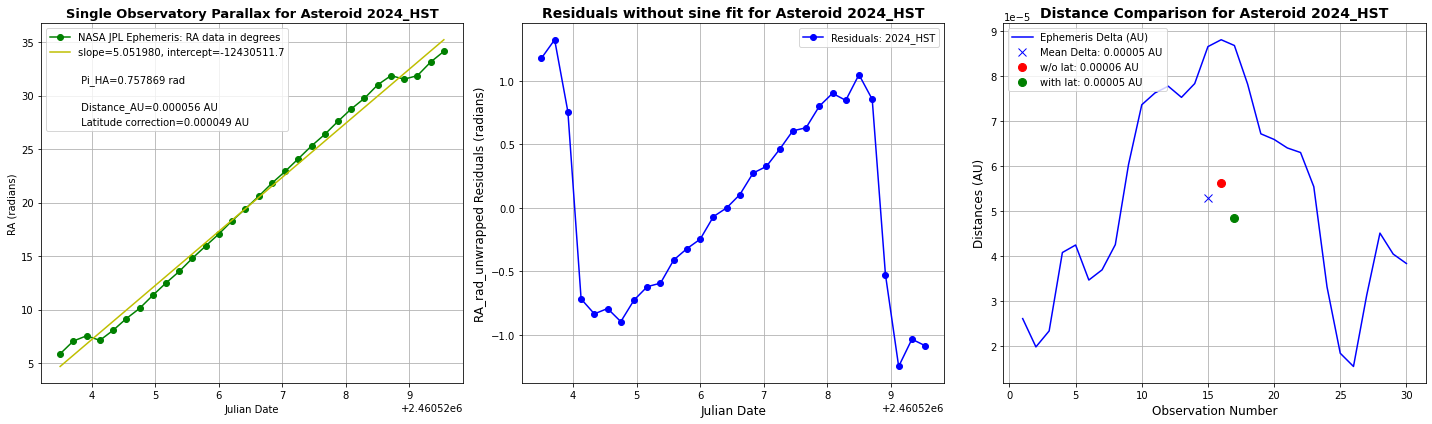

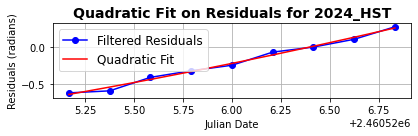

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.time import Time
import re
from astropy.coordinates import EarthLocation, AltAz
from astropy.coordinates import get_sun
from astropy.modeling import models, fitting
from matplotlib.font_manager import FontProperties
from scipy.stats import linregress

#--------------------------------------------------------------------------------------
# Load data and extract asteroid name
file_path = '11.1) Cerro_2024_HST_Diversity.xlsx'  # Change this to your actual file path
horizons_data = pd.read_excel(file_path)
asteroid_name = re.search(r'_(\d{4}_[A-Z]+)', file_path).group(1)

#--------------------------------------------------------------------------------------
AU_to_km = 149597870.7 
earth_radius_km = 6371

#--------------------------------------------------------------------------------------
# Dictionary to map observatory names to their latitudes
observatories = {
    'Cerro': -30.1692,            # Cerro Tololo Observatory
    'Castel_Gandolfo': 41.7412,   # Castel Gandolfo Observatory
    'Mt._Graham-VATT': 32.7016    # Mt. Graham-VATT Observatory
}

# Extract observatory name from the file name and select the corresponding latitude
observatory_name = re.search(r'(Cerro|Castel_Gandolfo|Mt\._Graham-VATT)', file_path).group(1)
lat_observatory = observatories[observatory_name]
theta_lat_rad = np.deg2rad(lat_observatory)
cos_theta_lat = np.cos(theta_lat_rad)
print(f"Selected Observatory: {observatory_name}, Latitude: {lat_observatory} degrees")
    
#--------------------------------------------------------------------------------------
# Function to convert RA from HMS to degrees
def hms_to_deg(hms_str):
    parts = re.split(r'\s+', hms_str.strip())
    h, m, s = [float(part) for part in parts]
    return 15 * (h + m/60 + s/3600) 

horizons_data.columns = horizons_data.columns.str.strip()
horizons_data['RA_deg'] = horizons_data['R.A._(ICRF)'].apply(hms_to_deg)
horizons_data['RA_rad'] = np.deg2rad(horizons_data['RA_deg'])
horizons_data['RA_rad_unwrapped'] = np.unwrap(horizons_data['RA_rad'])

#--------------------------------------------------------------------------------------
# Convert observation times to Julian Day (JD)
horizons_data['Date__(UT)__HR:MN'] = pd.to_datetime(horizons_data['Date__(UT)__HR:MN'], format='%Y-%b-%d %H:%M')
observation_times = Time(horizons_data['Date__(UT)__HR:MN'], scale='utc')
horizons_data['observation_times'] = observation_times
t_jd = observation_times.jd  
horizons_data['t_jd'] = t_jd
N_obs_all = len(t_jd)

horizons_data['delta_km'] = horizons_data['delta'] * AU_to_km

#--------------------------------------------------------------------------------------
# Fit a linear model to RA data
linear_model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()  
fitted_model = fitter(linear_model, t_jd, horizons_data['RA_rad_unwrapped'])  

slope = fitted_model.slope.value
intercept = fitted_model.intercept.value
RA_predicted = fitted_model(t_jd)

# Compute residuals
residuals = horizons_data['RA_rad_unwrapped'] - RA_predicted
residuals_squared = residuals ** 2
sum_squared_residuals = np.sum(residuals_squared)
mean_squared_residuals = sum_squared_residuals / N_obs_all
Pi_HA = np.sqrt(mean_squared_residuals) 

# Distance computations
Distance = earth_radius_km/Pi_HA
Distance_AU = Distance / AU_to_km

# Latitude correction
Distance_lat = cos_theta_lat * Distance
Distance_AU_lat = Distance_lat / AU_to_km

#--------------------------------------------------------------------------------------
# Create subplots for RA data, residuals, and distance comparisons
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot RA data and predictions
ax1.plot(t_jd,  horizons_data['RA_rad_unwrapped'], 'go-', label='NASA JPL Ephemeris: RA data in degrees')
ax1.plot(t_jd, RA_predicted, 'y-', label=f'slope={slope:.6f}, intercept={intercept:.1f}')
ax1.plot([], [], ' ', label=f'\n Pi_HA={Pi_HA:.6f} rad')
ax1.plot([], [], ' ', label=f'\n Distance_AU={Distance_AU:.6f} AU')
ax1.plot([], [], ' ', label=f' Latitude correction={Distance_AU_lat:.6f} AU')

ax1.set_xlabel('Julian Date')
ax1.set_ylabel('RA (radians)')
ax1.set_title(f"Single Observatory Parallax for Asteroid {asteroid_name}", fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True)

#--------------------------------------------------------------------------------------
# Plot residuals
ax2.plot(t_jd, residuals, 'bo-', label=f'Residuals: {asteroid_name}')
ax2.set_xlabel('Julian Date', fontsize=12)
ax2.set_ylabel('RA_rad_unwrapped Residuals (radians)', fontsize=12)
ax2.set_title(f"Residuals without sine fit for Asteroid {asteroid_name}", fontsize=14, fontweight='bold')
ax2.grid(True)
ax2.legend()

#--------------------------------------------------------------------------------------
# Plot distance comparisons
mean_delta = horizons_data['delta'].mean()
delta_values = horizons_data['delta'].values
ax3.plot(range(1, len(delta_values) + 1), delta_values, 'b-', label='Ephemeris Delta (AU)')
ax3.plot(len(delta_values) // 2, mean_delta, 'bx', label=f'Mean Delta: {mean_delta:.5f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 1, Distance_AU, 'ro', label=f'w/o lat: {Distance_AU:.5f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 2, Distance_AU_lat, 'go', label=f'with lat: {Distance_AU_lat:.5f} AU', markersize=8)
ax3.set_xlabel('Observation Number', fontsize=12)
ax3.set_ylabel('Distances (AU)', fontsize=12)
ax3.set_title(f"Distance Comparison for Asteroid {asteroid_name}", fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True)
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------
# Subtract quadratic fit and compute sine fit on residuals for days between 5 and 7
# Filtering for days between 2460525.4 and 2460526.6
t_jd_filtered = t_jd[(t_jd >= 2460525) & (t_jd <= 2460527)]
residuals_before_quadratic_filtered = residuals[(t_jd >= 2460525) & (t_jd <= 2460527)]

# Ensure that we have enough data points for fitting
if len(t_jd_filtered) == 0:
    print("Error: No data points in the specified date range.")
else:
    # Perform a quadratic fit on the filtered residuals
    t_jd_filtered_normalized = t_jd_filtered - np.mean(t_jd_filtered)  # Normalize Julian dates
    quadratic_model = models.Polynomial1D(degree=2)
    fitter_quadratic = fitting.LinearLSQFitter()
    fitted_quadratic_filtered = fitter_quadratic(quadratic_model, t_jd_filtered_normalized, residuals_before_quadratic_filtered)
    
    # Compute the predicted RA values from the quadratic model
    RA_quadratic_predicted_filtered = fitted_quadratic_filtered(t_jd_filtered_normalized)
    
    # Subtract quadratic fit to get residuals after quadratic fit
    residuals_after_quadratic_filtered = residuals_before_quadratic_filtered - RA_quadratic_predicted_filtered
    
  #################################  
    # Plot the quadratic fit separately
    plt.figure(figsize=(6, 2))
    plt.plot(t_jd_filtered, residuals_before_quadratic_filtered, 'bo-', label='Filtered Residuals')
    plt.plot(t_jd_filtered, RA_quadratic_predicted_filtered, 'r-', label='Quadratic Fit')
    
    plt.xlabel('Julian Date')
    plt.ylabel('Residuals (radians)')
    plt.title(f"Quadratic Fit on Residuals for {asteroid_name}", fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 ##################################   
    
    # Perform sine fitting on the residuals after subtracting the quadratic fit
    initial_amplitude = np.std(residuals_after_quadratic_filtered)  # Use standard deviation of residuals for amplitude
    sine_model_filtered = models.Sine1D(amplitude=initial_amplitude, frequency=1.0, phase=0.0)
    fitter_sine_filtered = fitting.LevMarLSQFitter()
    fitted_sine_filtered = fitter_sine_filtered(sine_model_filtered, t_jd_filtered_normalized, residuals_after_quadratic_filtered)
    
    # Predicted residuals after sine fit
    sine_predicted_filtered = fitted_sine_filtered(t_jd_filtered_normalized)
    
    # Final distance comparison using sine fit
    amplitude_radians_filtered = abs(fitted_sine_filtered.amplitude.value)
    distance_km_amplitude_filtered = earth_radius_km / amplitude_radians_filtered
    distance_au_amplitude_filtered = distance_km_amplitude_filtered / AU_to_km
    
    Distance_km_lat_corrected_amplitude_filtered = cos_theta_lat * distance_km_amplitude_filtered
    Distance_AU_lat_corrected_amplitude_filtered = Distance_km_lat_corrected_amplitude_filtered / AU_to_km

#--------------------------------------------------------------------------------------
# Plot the filtered residuals, sine fit, and distance comparison all in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: Sine Fit on residuals after subtracting quadratic fit
ax1.plot(t_jd_filtered, residuals_after_quadratic_filtered, 'bo-', label='Quadratic fit residuals')
ax1.plot(t_jd_filtered, sine_predicted_filtered, 'r-', label=(
    f'Amplitude = {fitted_sine_filtered.amplitude.value:.6f}, '
    f'\n Frequency = {fitted_sine_filtered.frequency.value:.6f}, '
    f'\n Phase = {fitted_sine_filtered.phase.value:.6f}'))
ax1.plot([], [], ' ', label=f'Distance from Amp = {distance_au_amplitude_filtered:.6f} AU')
ax1.plot([], [], ' ', label=f'Latitude correction = {Distance_AU_lat_corrected_amplitude_filtered:.6f} AU')
ax1.set_xlabel('Julian Date')
ax1.set_ylabel('RA Residuals (radians)')
ax1.set_title(f"Sine Fit on Quadratic Residuals for {asteroid_name}", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True)

# Subplot 2: Final distance comparison using sine amplitude fit
bars = ax2.bar(['Without Latitude Correction', 'With Latitude Correction'],
               [distance_au_amplitude_filtered, Distance_AU_lat_corrected_amplitude_filtered],
               color='tab:red', alpha=0.6, label='Distance in AU')

for bar, distance1 in zip(bars, [distance_au_amplitude_filtered, Distance_AU_lat_corrected_amplitude_filtered]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f'{distance1:.6f} AU', ha='center', va='bottom', fontsize=12)

ax2.axhline(mean_delta, color='green', linestyle='--', label=f'Mean Delta: {mean_delta:.6f} AU')
ax2.set_xlabel('Condition')
ax2.set_ylabel('Distance (AU)')
ax2.legend(loc='upper right', fontsize=10)
ax2.set_title(f'Bar distance comparison for {asteroid_name}', fontsize=14, fontweight='bold')
ax2.grid(True)

# Subplot 3: Another plot comparison for delta values with and without latitude corrections
ax3.plot(range(1, len(delta_values) + 1), delta_values, 'b-', label='Ephemeris Delta (AU)')
ax3.plot(len(delta_values) // 2, mean_delta, 'bx', label=f'Mean Delta: {mean_delta:.8f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 1, distance_au_amplitude_filtered, 'ro', label=f'w/o lat: {distance_au_amplitude_filtered:.8f} AU', markersize=8)
ax3.plot(len(delta_values) // 2 + 2, Distance_AU_lat_corrected_amplitude_filtered, 'go', label=f'with lat: {Distance_AU_lat_corrected_amplitude_filtered:.8f} AU')
ax3.set_xlabel('Observation Number')
ax3.set_ylabel('Distances (AU)')
ax3.set_title(f"{asteroid_name} \n Distance Comparisons", fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True)

# Adjust layout
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()
